In [20]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torch.utils.data import ConcatDataset
import optuna
from segmentation_models_pytorch.losses import DiceLoss
import wandb
import torchvision

In [21]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using {device} device")

Using cpu device


In [23]:
#loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = nn.MSELoss().to(device, dtype=torch.float)

In [25]:
class WaterBodiesDataset(Dataset):
    def __init__(self, data_dir, split="train", test_size=0.15, val_size=0.15, transform=None):

        assert split in ["train", "val", "test"], "Split must be 'train', 'val' or 'test'"
        
        image_paths = sorted(glob.glob(os.path.join(data_dir, "Images", "*.jpg")))
        mask_paths = sorted(glob.glob(os.path.join(data_dir, "Masks", "*.jpg")))

        assert len(image_paths) == len(mask_paths), "Mismatch between images and masks count!"

        total_size = len(image_paths)
        test_count = int(test_size * total_size)
        val_count = int(val_size * total_size) 
        train_count = total_size - test_count - val_count  

        if split == "test":
            selected_indices = list(range(test_count))
        elif split == "val":
            selected_indices = list(range(test_count + train_count, total_size))
        else: 
            selected_indices = list(range(test_count, test_count + train_count))

        self.image_paths = [image_paths[i] for i in selected_indices]
        self.mask_paths = [mask_paths[i] for i in selected_indices]
        self.transform = A.Compose([
            A.Resize(256, 256),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        img, mask = np.array(img), np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

In [26]:
def get_dataloaders(data_dir, batch_size=16, shuffle=True, num_workers=0):
    train_dataset = WaterBodiesDataset(data_dir, split="train")
    val_dataset = WaterBodiesDataset(data_dir, split="val")
    test_dataset = WaterBodiesDataset(data_dir, split="test")
    full_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)


    print(f'Train dataset: {len(train_dataset)}')
    print(f'Test dataset: {len(test_dataset)}')
    print(f'Val dataset: {len(val_dataset)}')
    print(f'Full dataset: {len(full_dataset)}')

    return train_loader, val_loader, test_loader, full_loader

In [27]:
# Added full_dataloader which contains full dataset in one place
train_dataloader, val_dataloader, test_dataloader, full_dataloader = get_dataloaders('C:/Users/Admin/Downloads/data/data/WaterBodiesDataset')


assert len(train_dataloader) > 0
assert len(val_dataloader) > 0 
assert len(test_dataloader) > 0

Train dataset: 1989
Test dataset: 426
Val dataset: 426
Full dataset: 2841


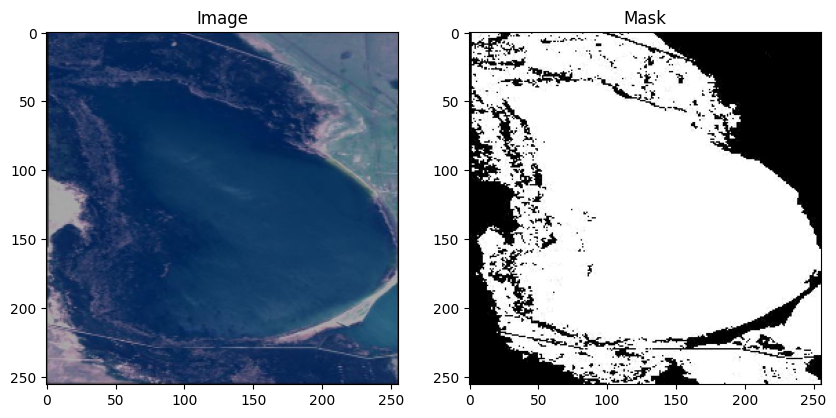

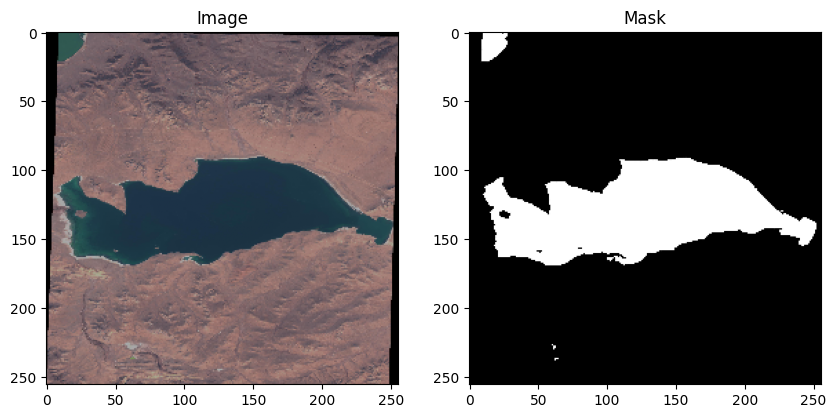

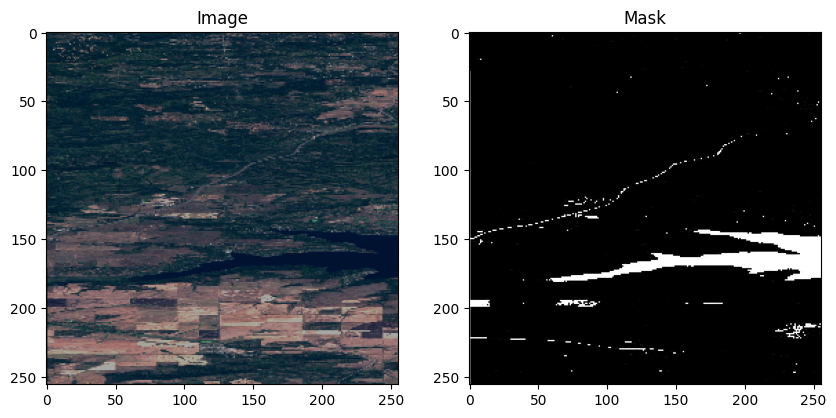

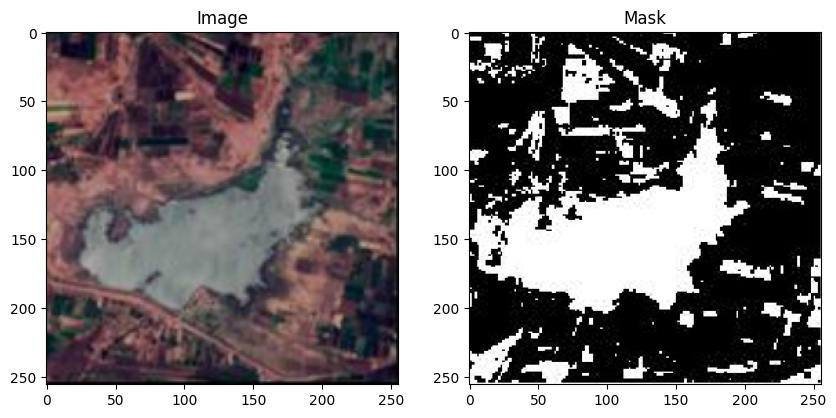

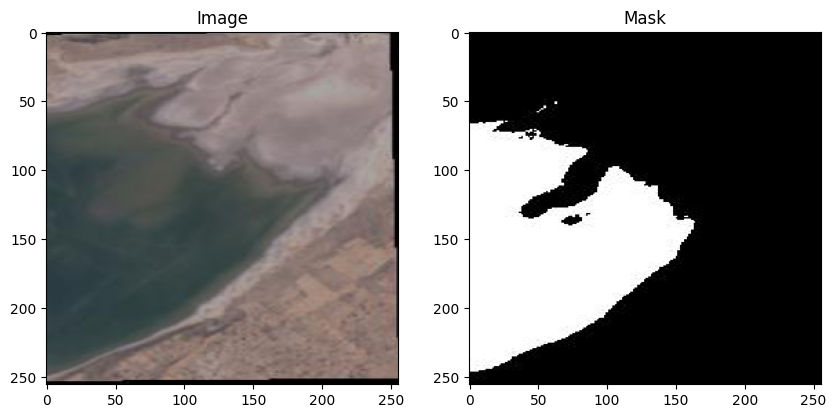

In [12]:
# Data display
def visualize_sample(image, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image.transpose(0, 1).transpose(1, 2))  # Convert back to HWC format
    ax[0].set_title('Image')
    ax[1].imshow(mask.squeeze(), cmap='gray')  # Remove the channel dimension for mask
    ax[1].set_title('Mask')
    plt.show()

# Get a batch from the dataloader
for batch in full_dataloader:
    images, masks = batch
    for i in range(5):
        visualize_sample(images[i], masks[i])
    break  # Only one batch

In [144]:
for batch in full_dataloader:
    images, masks = batch
    print(f'Image shape: {images.shape}')  # (batch_size, channels, height, width)
    print(f'Mask shape: {masks.shape}')    # (batch_size, channels, height, width)
    break

Image shape: torch.Size([16, 3, 256, 256])
Mask shape: torch.Size([16, 1, 256, 256])


In [152]:
percentages = []
for batch in full_dataloader:
    images, masks = batch
    for image, mask in zip(images, masks):
        black_pixels = torch.sum(mask > 0.5).item()
        total_pixels = mask.numel()
        black_percentage = (black_pixels / total_pixels) * 100
        if black_percentage != 100: # some pictures are broken
            percentages.append(black_percentage)

In [153]:
# Average water percentage
print(sum(percentages)/len(percentages))

29.8493981098234


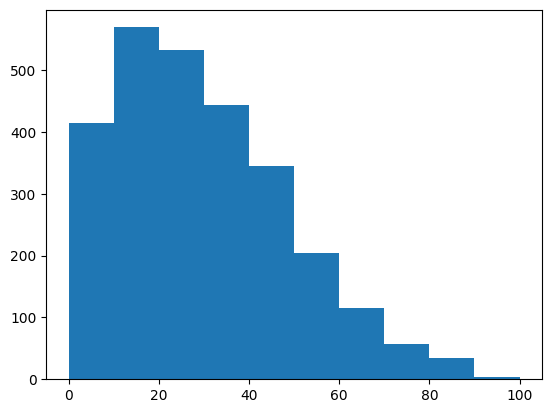

In [154]:
plt.hist(percentages, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

An additional insight I gained during data visualisation is that some pictures (and their corresponding masks) are broken. These typically have their masks only consisting of 1s. Below, there are some examples of broken images as well as the percentage of broken images. It's very insightful to know that some data is broken or corrupted - maybe it would be appropriate to remove these images from the set (I didn't do it tho).

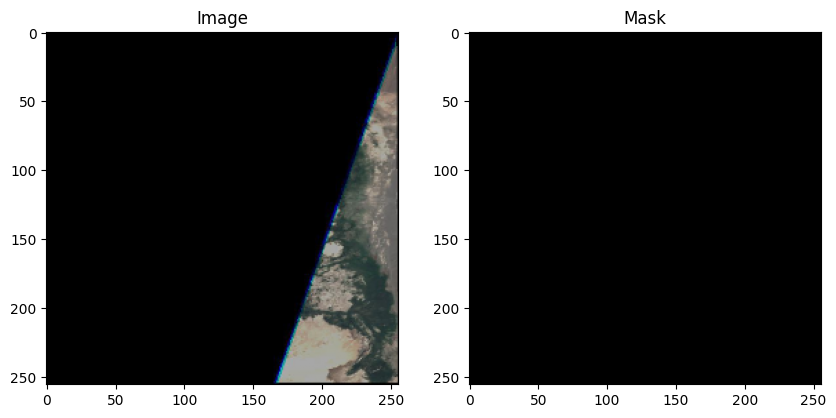

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], dtype=torch.float64)


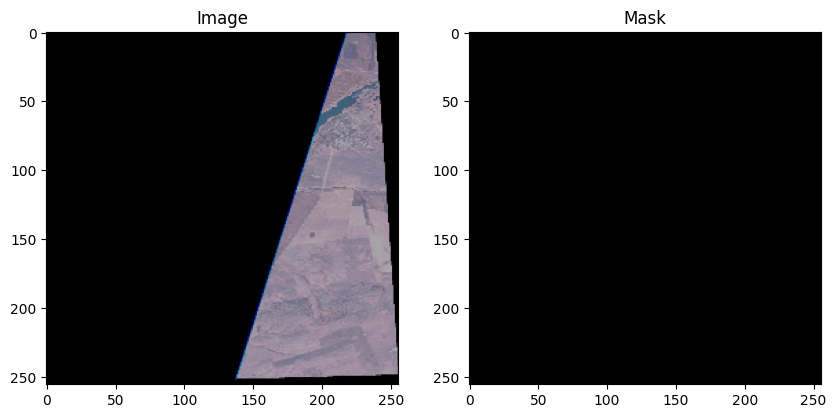

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], dtype=torch.float64)


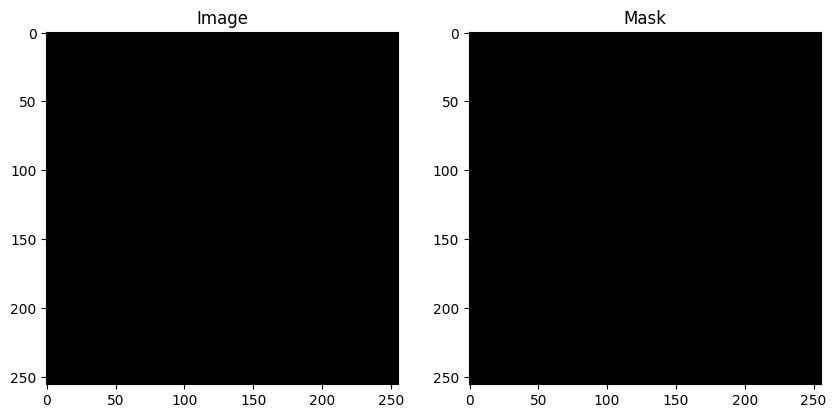

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], dtype=torch.float64)


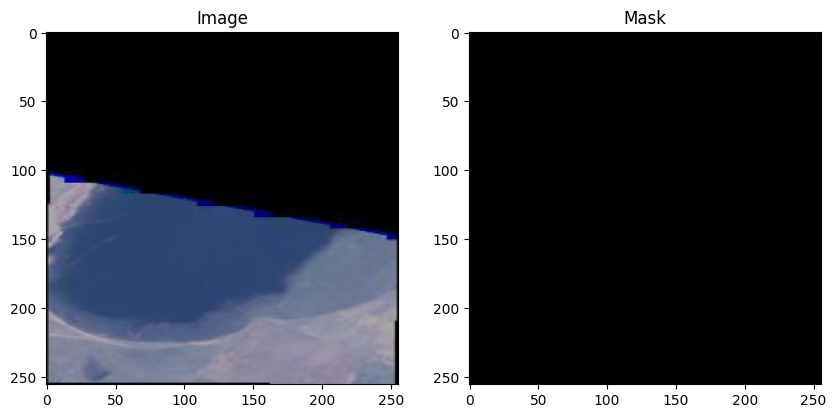

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], dtype=torch.float64)


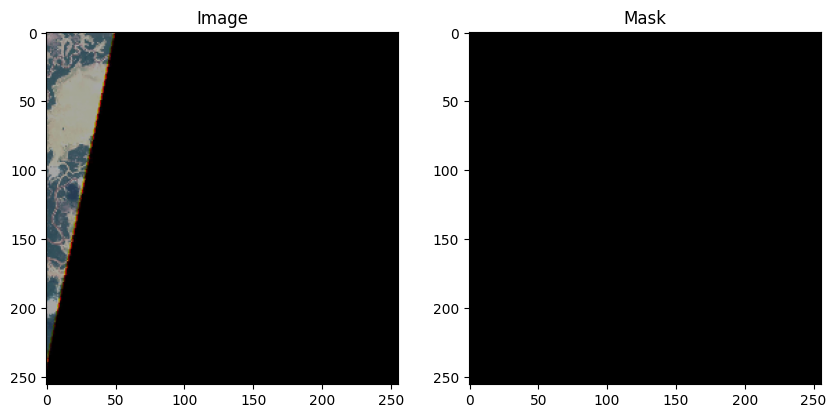

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], dtype=torch.float64)


In [174]:
broken_images = 0
all_images = 0
count = 5
for batch in full_dataloader:
    images, masks = batch
    for image, mask in zip(images, masks):
        black_pixels = torch.sum(mask > 0.5).item()
        total_pixels = mask.numel()
        black_percentage = (black_pixels / total_pixels) * 100
        all_images += 1
        if black_percentage == 100:
            broken_images += 1
            if count > 0:
                visualize_sample(image, mask)
                print(mask)
                count -= 1

In [175]:
print(broken_images/all_images * 100)

4.329461457233368


In [28]:
wandb.init(project="segmentation_model", entity="dominikbiernacki-wroclaw-university")

In [31]:
# Only taking half of the training set
from torch.utils.data import random_split

subset_size = len(train_dataloader.dataset) // 2
small_train_dataset, _ = random_split(train_dataloader.dataset, [subset_size, len(train_dataloader.dataset) - subset_size])

small_train_dataloader = torch.utils.data.DataLoader(
    small_train_dataset, batch_size=train_dataloader.batch_size, shuffle=True
)

In [32]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model = model.double()


In [33]:
losses = []

In [34]:
def train(dataloader, model, loss_fn, optimizer):
    global losses
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            losses.append(loss)
            wandb.log({"Loss/train": loss})
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        if batch % 5 == 0:
            with torch.no_grad():
                model.eval()
                inputs, labels = X.cpu(), y.cpu()
                predictions = torch.sigmoid(pred).cpu() > 0.5

                # Log original images
                grid = torchvision.utils.make_grid(inputs)
                wandb.log({"Images": [wandb.Image(grid)]})

                # Log predicted segmentation masks
                grid_pred = torchvision.utils.make_grid(predictions.float())
                wandb.log({"Predictions": [wandb.Image(grid_pred)]})

In [35]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += np.mean(((pred.cpu().detach() > 0.5) == (y.cpu() > 0.5)).type(torch.float).numpy(), axis=(1,2,3)).sum()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [37]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(small_train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.744631  [   16/  994]
loss: 0.382389  [   96/  994]
loss: 0.237565  [  176/  994]
loss: 0.246079  [  256/  994]
loss: 0.202645  [  336/  994]
loss: 0.247732  [  416/  994]
loss: 0.255257  [  496/  994]
loss: 0.189650  [  576/  994]
loss: 0.198444  [  656/  994]
loss: 0.270656  [  736/  994]
loss: 0.195944  [  896/  994]
loss: 0.198797  [  816/  994]
loss: 0.203385  [  976/  994]
Test Error: 
 Accuracy: 65.6%, Avg loss: 0.217048 

Epoch 2
-------------------------------
loss: 0.707177  [   16/  994]
loss: 0.223434  [   96/  994]
loss: 0.218308  [  176/  994]
loss: 0.225519  [  256/  994]
loss: 0.210194  [  336/  994]
loss: 0.222324  [  416/  994]
loss: 0.230509  [  496/  994]
loss: 0.215043  [  576/  994]
loss: 0.192440  [  656/  994]
loss: 0.199603  [  736/  994]
loss: 0.195287  [  816/  994]
loss: 0.174522  [  896/  994]
loss: 0.165300  [  976/  994]
Test Error: 
 Accuracy: 75.3%, Avg loss: 0.189559 

Epoch 3
----------------------------

In [38]:
test(val_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.146157 



np.float32(80.543495)

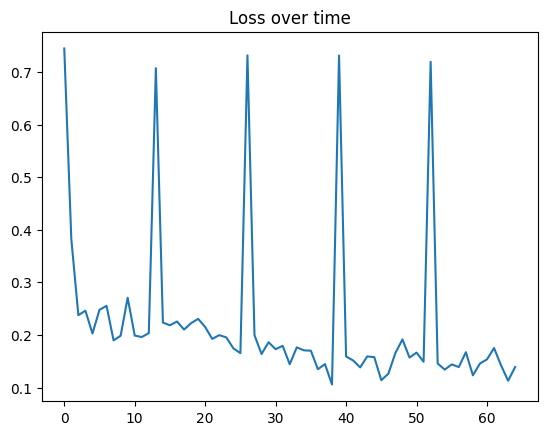

In [39]:
plt.plot(losses)
plt.title("Loss over time")
plt.show()

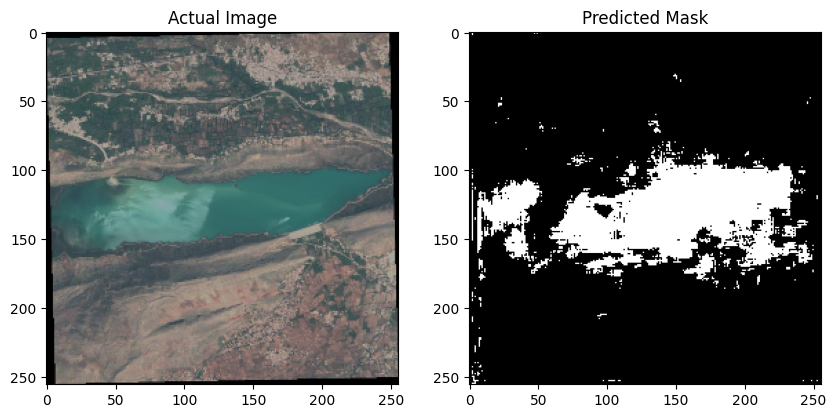

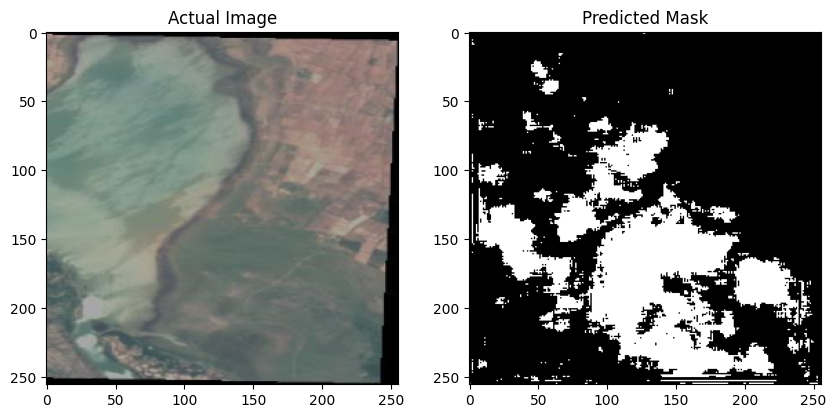

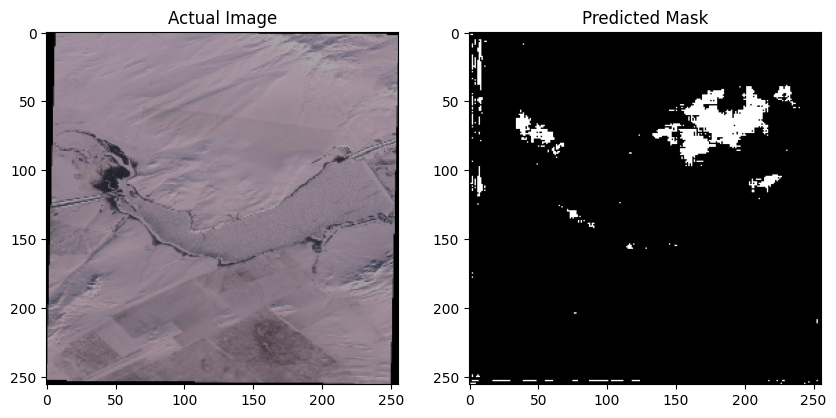

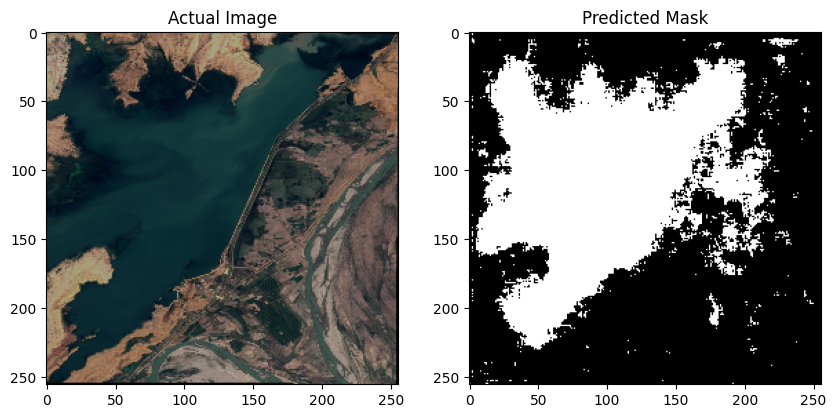

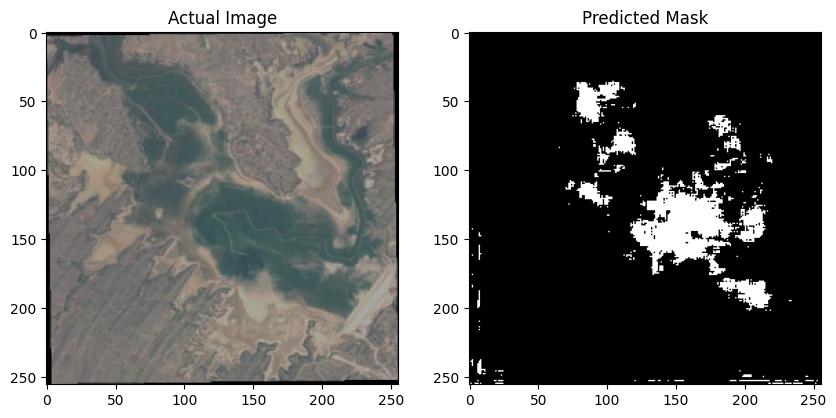

In [42]:
model.eval()

# Function to visualize the actual image and its predicted mask
def visualize_prediction(image, prediction):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image.transpose(0, 1).transpose(1, 2))
    ax[0].set_title('Actual Image')
    ax[1].imshow(prediction.squeeze(), cmap='gray')
    ax[1].set_title('Predicted Mask')
    plt.show()
    
    
for images, masks in val_dataloader:
    for i in range(5):
        image = images[i] 
        mask = masks[i]
        image = image.unsqueeze(0)
        image = image.to(device)
        with torch.no_grad():
            prediction = model(image)
        prediction = (prediction > 0.5).float()
        visualize_prediction(image.cpu().squeeze(), prediction.cpu().squeeze())
    break

I mean... they kinda look like the actual image - more epochs and using the whole dataset could make predictions work much better.

In [43]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [44]:
model = smp.Unet("resnet50", encoder_weights=None, in_channels=3, classes=1).to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model = model.double()
test(val_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.146157 



np.float32(80.54348)

In [196]:
def objective(trial): 
    # Suggest loss function and learning rate
    loss_fn_choice = trial.suggest_categorical("loss_function", ["DiceLoss", "BCEWithLogitsLoss"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)  # Learning rate between 1e-5 and 1e-1

    # Create model
    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    )
    model = model.double()
    
    # Choose loss function based on trial suggestion
    if loss_fn_choice == "DiceLoss":
        loss_fn = DiceLoss(mode='binary')
    else:
        loss_fn = nn.BCEWithLogitsLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Train and evaluate
    train(small_train_dataloader, model, loss_fn, optimizer)
    accuracy = test(test_dataloader, model, loss_fn)

    return accuracy

# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print the best result
print("Best trial:")
trial = study.best_trial
print(f"Loss function: {trial.params['loss_function']}")
print(f"Learning rate: {trial.params['lr']}")
print(f"Best validation accuracy: {trial.value:.4f}")

[I 2025-03-13 21:21:59,419] A new study created in memory with name: no-name-227cb87c-89e9-4c4d-812b-12a697355b9c
C:\Users\Admin\AppData\Local\Temp\ipykernel_8868\2793134547.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)  # Learning rate between 1e-5 and 1e-1


loss: 0.653023  [   16/  994]
loss: 0.621772  [  176/  994]
loss: 0.650895  [  336/  994]
loss: 0.670700  [  496/  994]
loss: 0.649768  [  656/  994]
loss: 0.569797  [  816/  994]
loss: 0.578057  [  976/  994]


[I 2025-03-13 21:24:00,456] Trial 0 finished with value: 63.629066467285156 and parameters: {'loss_function': 'DiceLoss', 'lr': 0.002121418050538551}. Best is trial 0 with value: 63.629066467285156.


Test Error: 
 Accuracy: 63.6%, Avg loss: 0.543467 

loss: 0.601535  [   16/  994]
loss: 0.463849  [  176/  994]
loss: 0.504851  [  336/  994]
loss: 0.548756  [  496/  994]
loss: 0.581802  [  656/  994]
loss: 0.511582  [  816/  994]
loss: 0.640210  [  976/  994]


[I 2025-03-13 21:26:00,468] Trial 1 finished with value: 53.72967529296875 and parameters: {'loss_function': 'DiceLoss', 'lr': 1.0642739101632606e-05}. Best is trial 0 with value: 63.629066467285156.


Test Error: 
 Accuracy: 53.7%, Avg loss: 0.516952 

loss: 0.618238  [   16/  994]
loss: 0.598048  [  176/  994]
loss: 0.644193  [  336/  994]
loss: 0.581889  [  496/  994]
loss: 0.658439  [  656/  994]
loss: 0.670210  [  816/  994]
loss: 0.580793  [  976/  994]


[I 2025-03-13 21:28:00,720] Trial 2 finished with value: 62.77629089355469 and parameters: {'loss_function': 'DiceLoss', 'lr': 3.761287739633114e-05}. Best is trial 0 with value: 63.629066467285156.


Test Error: 
 Accuracy: 62.8%, Avg loss: 0.583015 

loss: 0.652482  [   16/  994]
loss: 0.552976  [  176/  994]
loss: 0.414358  [  336/  994]
loss: 0.390731  [  496/  994]
loss: 0.439743  [  656/  994]
loss: 0.355456  [  816/  994]
loss: 0.251863  [  976/  994]


[I 2025-03-13 21:30:01,304] Trial 3 finished with value: 61.644535064697266 and parameters: {'loss_function': 'DiceLoss', 'lr': 0.08752939928772137}. Best is trial 0 with value: 63.629066467285156.


Test Error: 
 Accuracy: 61.6%, Avg loss: 0.413201 

loss: 0.540087  [   16/  994]
loss: 0.605182  [  176/  994]
loss: 0.466629  [  336/  994]
loss: 0.421306  [  496/  994]
loss: 0.431736  [  656/  994]
loss: 0.435096  [  816/  994]
loss: 0.415386  [  976/  994]


[I 2025-03-13 21:32:02,304] Trial 4 finished with value: 60.624759674072266 and parameters: {'loss_function': 'DiceLoss', 'lr': 0.04899612375830601}. Best is trial 0 with value: 63.629066467285156.


Test Error: 
 Accuracy: 60.6%, Avg loss: 0.432280 

loss: 0.728736  [   16/  994]
loss: 0.773911  [  176/  994]
loss: 0.753392  [  336/  994]
loss: 0.777598  [  496/  994]
loss: 0.751759  [  656/  994]
loss: 0.763065  [  816/  994]
loss: 0.758011  [  976/  994]


[I 2025-03-13 21:33:59,154] Trial 5 finished with value: 59.07744598388672 and parameters: {'loss_function': 'BCEWithLogitsLoss', 'lr': 1.1279238808662232e-05}. Best is trial 0 with value: 63.629066467285156.


Test Error: 
 Accuracy: 59.1%, Avg loss: 0.797927 

loss: 0.752502  [   16/  994]
loss: 0.654088  [  176/  994]
loss: 0.662105  [  336/  994]
loss: 0.549747  [  496/  994]
loss: 0.482666  [  656/  994]
loss: 0.523346  [  816/  994]
loss: 0.430297  [  976/  994]


[I 2025-03-13 21:35:44,730] Trial 6 finished with value: 71.89494323730469 and parameters: {'loss_function': 'BCEWithLogitsLoss', 'lr': 0.02144443830890565}. Best is trial 6 with value: 71.89494323730469.


Test Error: 
 Accuracy: 71.9%, Avg loss: 0.711378 

loss: 0.870796  [   16/  994]
loss: 0.863342  [  176/  994]
loss: 0.875363  [  336/  994]
loss: 0.942567  [  496/  994]
loss: 0.873423  [  656/  994]
loss: 0.881016  [  816/  994]
loss: 0.866328  [  976/  994]


[I 2025-03-13 21:37:29,960] Trial 7 finished with value: 55.08133316040039 and parameters: {'loss_function': 'BCEWithLogitsLoss', 'lr': 0.0002605009178240923}. Best is trial 6 with value: 71.89494323730469.


Test Error: 
 Accuracy: 55.1%, Avg loss: 0.913177 

loss: 0.705475  [   16/  994]
loss: 0.640706  [  176/  994]
loss: 0.568893  [  336/  994]
loss: 0.589163  [  496/  994]
loss: 0.470370  [  656/  994]
loss: 0.497810  [  816/  994]
loss: 0.466003  [  976/  994]


[I 2025-03-13 21:39:14,557] Trial 8 finished with value: 76.53630828857422 and parameters: {'loss_function': 'BCEWithLogitsLoss', 'lr': 0.0430883949793525}. Best is trial 8 with value: 76.53630828857422.


Test Error: 
 Accuracy: 76.5%, Avg loss: 0.530286 

loss: 0.603829  [   16/  994]
loss: 0.566985  [  176/  994]
loss: 0.505116  [  336/  994]
loss: 0.493665  [  496/  994]
loss: 0.551774  [  656/  994]
loss: 0.523390  [  816/  994]
loss: 0.515351  [  976/  994]


[I 2025-03-13 21:40:59,505] Trial 9 finished with value: 59.74224090576172 and parameters: {'loss_function': 'DiceLoss', 'lr': 0.003006048376089973}. Best is trial 8 with value: 76.53630828857422.


Test Error: 
 Accuracy: 59.7%, Avg loss: 0.498310 

Best trial:
Loss function: BCEWithLogitsLoss
Learning rate: 0.0430883949793525
Best validation accuracy: 76.5363
